 **SMS spam dataset**

In [1]:
import pandas as pd
sms = pd.read_csv('sms-spam.csv')
print('lenght: {}'.format(len(sms)))
print('number of spams: {}'.format(sms.spam.sum()))
sms.head()

lenght: 4837
number of spams: 638


,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**convert to tf-idf vector**

In [2]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(sms.text).toarray()
tfidf_docs.shape

(4837, 9232)

# LDA Classifier

**Tính toán tâm của các điểm dữ liệu trong mỗi chủ đề**

In [3]:
mask = sms.spam.astype(bool).values
mask

array([False, False,  True, ..., False, False, False])

In [4]:
spam_centroid = tfidf_docs[mask].mean(axis = 0)
nspam_centroid = tfidf_docs[~mask].mean(axis=0)

In [5]:
spam_centroid.round(2)

array([0.06, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])

In [6]:
nspam_centroid.round(2)

array([0.02, 0.01, 0.  , ..., 0.  , 0.  , 0.  ])

**Tính toán đường nối 2 tâm**

In [7]:
line = spam_centroid - nspam_centroid
line

array([ 4.39266024e-02, -1.92685506e-03,  3.84287194e-04, ...,
       -6.31869803e-05, -6.31869803e-05, -6.31869803e-05])

**Chiếu các vector tfidf lên đường nối đó**

In [8]:
spam_score = tfidf_docs.dot(line)
spam_score.round(2)

array([-0.01, -0.02,  0.04, ..., -0.01, -0.  ,  0.  ])

**Chuyển về dạng xác suất**

sử dụng threshole = 0.5 để xác định spam sms

In [9]:
from sklearn.preprocessing import MinMaxScaler
sms['lda_scale_score'] = MinMaxScaler().fit_transform(spam_score.reshape(-1,1))
sms['spam_score'] = spam_score
sms['lds_predict']=(sms.lda_scale_score>0.5).astype(int)
sms.head(6)

,spam,text,lda_scale_score,spam_score,lds_predict
0,0,"Go until jurong point, crazy.. Available only ...",0.227478,-0.014698,0
1,0,Ok lar... Joking wif u oni...,0.177888,-0.020074,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,0.038561,1
3,0,U dun say so early hor... U c already then say...,0.184565,-0.019350,0
4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,-0.008252,0
5,1,FreeMsg Hey there darling it's been 3 week's n...,0.548003,0.020048,1


**Đánh giá mô hình**

In [10]:
model_score = (1-(sms.spam - sms.lds_predict).abs().sum()/len(sms)).round(3)
model_score

0.977

# Understanding SVD Implementation


https://github.com/totalgood/nlpia/blob/master/src/nlpia/book/examples/ch04_catdog_lsa_sorted.py

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

Hàm docs_to_tdm thực hiện chuyển tập văn bản thành ma trận term-document (tdm) trong đó bao gồm:
- ma trận tfidf trong đó vector hàng là vector tfidf cho mỗi văn bản
- ma trận Bag-of-words(BOW) trong đó vector hàng là vector BOW cho mỗi văn bản

Hàm trả về ma trận tfidf, bow và mô hình dùng để vector hóa đã được huấn luyện

In [12]:
def docs_to_tdm(docs, vocabulary):
    tfidfer = TfidfVectorizer(tokenizer = casual_tokenize, vocabulary = vocabulary)
    # make a tf-idf matrix using todense()
    tfidf_matrix = pd.DataFrame(tfidfer.fit_transform(docs).todense())
    id_words = [(i, w) for (w, i) in tfidfer.vocabulary_.items()]
    tfidf_matrix.columns = list(zip(*sorted(id_words)))[1]
    
    tfidfer.use_idf = False
    tfidfer.norm = None
    bow_matrix = pd.DataFrame(tfidfer.fit_transform(docs).todense())
    bow_matrix.columns = list(zip(*sorted(id_words)))[1]
    bow_matrix = bow_matrix.astype(int)
    tfidfer.use_idf = True
    tfidfer.norm = 'l2'
    return bow_matrix.T, tfidf_matrix.T, tfidfer 

Hàm lsa dùng để phân tích ma trận term-document thành các ma trận u, s, vt bằng cách sử dụng hàm **svd** trong thư viện numpy

trong đó: 
tdm = u.s.vt

In [31]:
def lsa(tdm):
    u, s, vt = np.linalg.svd(tdm)
    u = pd.DataFrame(u, index=tdm.index)
    vt = pd.DataFrame(vt, index = ['d{}'.format(i) for i in range(len(vt))])
    print('\nTerm-document matrix:\n')
    print(tdm)
    print('\nU\n')
    print(u.round(2))
    print('\nS diagonal\n')
    print(s.round(2))
    print('\nVT\n')
    print(vt.round(2))
    return {'u': u, 's': s, 'vt':vt, 'tdm':tdm}

Hàm accuracy_study thực hiện tính toán lỗi trong mỗi lần thực hiện giảm số chiều của dữ liệu.

Để giảm số chiều dữ liệu, ta thực hiện thay giá trị trên đường chéo của ma trận S thành 0 theo chiều từ dưới lên trên (phải qua trái) tức là theo mức độ giảm tính quan trọng của topic

Error được đo bằng sự sai khác giữa ma trận tdm ban đầu và ma trận tdm lúc sau (tích của u, s, vt sau khi đã giảm số chiều). Mỗi lần giảm error sẽ được ghi lại vào mảng

In [ ]:
def accuracy_study(tdm= None, u = None, s = None, vt = None, **kwargs):
    smat = np.zeros((len(u), len(vt)))
    np.fill_diagonal(smat, s)
    smat = pd.DataFrame(smat, columns = vt.index, index = u.index)
    tdm_prime = u.values.dot(smat.values).dot(vt.values)
    err = [np.sqrt(((tdm_prime-tdm).values.flatten()**2).sum()/np.product(tdm.shape))]
    
    smat2 = smat.copy()
    for numdim in range(len(s)-1, 0, -1):
        smat2.iloc[numdim, numdim]=0
        tdm_prime2 = u.values.dot(smat2.values).dot(vt.values)
        err += [np.sqrt(((tdm_prime2-tdm).values.flatten()**2).sum()/np.product(tdm.shape))]
    return err

Vẽ biểu đồ thể hiện sự mất mát thông tin sau mỗi lần giảm số chiều

In [ ]:
def plot_feature_selection(accuracy):
    plt.plot(range(len(accuracy)), accuracy)
    plt.title('LSA Model Accuracy')
    plt.xlabel('Number of Dimensions Eliminated')
    plt.ylabel('Reconstruction Accuracy')
    plt.grid(True)
    plt.tight_layout()
    return accuracy

Xây dựng mô hình lsa bao gồm các thuộc tính: ma trận s, u, vt, tập từ vựng, tập văn bản, độ chính xác, lỗi
    
Ở đây lsa_models sẽ trả về 2 model : một cái dựa theo tfidf, một cái dựa theo bow

In [13]:
def lsa_models(vocabulary= None, docs= None):
    tdm, tfidfdm, tfidfer = docs_to_tdm(docs = docs, vocabulary = vocabulary)
    lsa_bow_model = lsa(tdm)
    lsa_bow_model['vocabulary'] = tdm.index.values
    lsa_bow_model['docs'] = docs
    err = accuracy_study(**lsa_bow_model)
    lsa_bow_model['err'] = err
    lsa_bow_model['accuracy'] = list(1.-np.array(err))
    
    lsa_tfidf_model = lsa(tfidfdm)
    lsa_tfidf_model['vocabulary'] = tfidfdm.index.values
    lsa_tfidf_model['docs'] = docs
    err = accuracy_study(**lsa_tfidf_model)
    lsa_tfidf_model['err'] = err
    lsa_tfidf_model['accuracy'] = list(1.-np.array(err))
    
    return lsa_bow_model, lsa_tfidf_model


Term-document matrix:

       0  1  2  3  4  5  6  7  8  9  10
cat    0  0  0  0  0  0  1  1  1  0   1
dog    0  0  0  0  0  0  0  0  0  0   1
apple  1  1  0  1  1  1  0  0  0  0   0
lion   0  0  0  0  0  0  0  1  0  0   0
nyc    1  1  1  1  1  0  0  0  0  1   0
love   0  0  1  0  0  0  0  0  1  1   0

U

          0     1     2     3     4     5
cat   -0.04  0.83 -0.38  0.00  0.11 -0.38
dog   -0.00  0.21 -0.18 -0.71 -0.39  0.52
apple -0.62 -0.21 -0.51  0.00  0.49  0.27
lion  -0.00  0.21 -0.18  0.71 -0.39  0.52
nyc   -0.75 -0.00  0.24 -0.00 -0.52 -0.32
love  -0.22  0.42  0.69  0.00  0.41  0.37

S diagonal

[3.14 2.24 1.77 1.   0.84 0.52]

VT

        0     1     2     3     4     5     6     7     8     9    10
d0  -0.44 -0.44 -0.31 -0.44 -0.44 -0.20 -0.01 -0.01 -0.08 -0.31 -0.01
d1  -0.09 -0.09  0.19 -0.09 -0.09 -0.09  0.37  0.47  0.56  0.19  0.47
d2  -0.16 -0.16  0.52 -0.16 -0.16 -0.29 -0.22 -0.32  0.17  0.52 -0.32
d3   0.00 -0.00 -0.00 -0.00 -0.00  0.00 -0.00  0.71  0.00 -0.00 -0.7

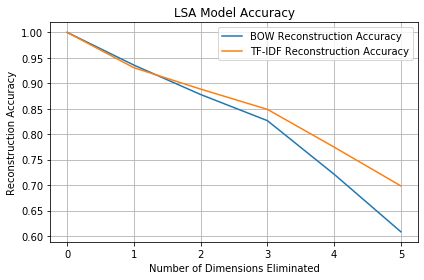

In [32]:
numdocs = 11
docs = """NYC is the Big Apple.
NYC is known as the Big Apple.
I love NYC!
I wore a hat to the Big Apple party in NYC.
Come to NYC. See the Big Apple!
Manhattan is called the Big Apple.
New York is a big city for a small cat.
The lion, a big cat, is the king of the jungle.
I love my pet cat.
I love New York City (NYC).
Your dog chased my cat.""".split('\n')
vocabulary = 'cat dog apple lion NYC love'.lower().split()
lsa_bow_model, lsa_tfidf_model = lsa_models(vocabulary = vocabulary, docs = docs)
tdm = lsa_bow_model['tdm']
tfidfdm = lsa_tfidf_model['tdm']

acc = plot_feature_selection(accuracy = lsa_bow_model['accuracy'])
print("BOW accuracy after multiplying Truncated SVD back:")
print(np.array(acc).round(3))

acc = plot_feature_selection(accuracy = lsa_tfidf_model['accuracy'])
print("TF-IDF accuracy after multiplying Truncated SVD back:")
print(np.array(acc).round(3))

plt.legend(['BOW Reconstruction Accuracy', 'TF-IDF Reconstruction Accuracy'])
plt.show()

# Construct topic matrix for corpus

**Có 2 cách: dùng mô hình PCA hoặc dùng TruncatedSVD.**

**Tuy nhiên, TruncatedSVD thường được dùng cho ma trận thưa**


## PCA for building topic matrix

mô hình PCA là mô hình sử dụng ý tưởng SVD để giảm số chiều. PCA sẽ có thêm một số cải tiến so với SVD để cải thiện đội chính xác khi áp dụng cho NLP.
Đầu tiên, PCA center dữ liệu. Tức là, PCA gán lại mỗi điểm dữ liệu = hiệu của nó với giá trị trung bình của toàn bộ dữ liệu. Khi đó độ lệch chuẩn của bộ dữ liệu không đổi và kỳ vọng của nó =0. 

Ngoài ra PCA còn có một function: flip_sign để tính toán dấu của các singular vectors. Với giá trị cho đường chéo trên ma trận S, thay vì chuyển hết về 1 như SVD, PCA sẽ thay vào đó bằng thương của dữ liệu và phương sai của nó (giống như StandardScaler) 


Thực hiện xây dựng mô hình pca, đầu vào là term-document matrix (cụ thể là tfidf matrix) đã được centering

In [15]:
sms = pd.read_csv('sms-spam.csv')
print('lenght: {}'.format(len(sms)))
print('number of spams: {}'.format(sms.spam.sum()))
index = ['sms{}{}'.format(i, '!'*j) for (i, j) in zip(range(len(sms)), sms.spam)]
sms.index = index
sms.head()

lenght: 4837
number of spams: 638


,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(sms.text).toarray()
tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs = tfidf_docs - tfidf_docs.mean() #centering data

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 16)
pca = pca.fit(tfidf_docs)

Từ mô hình pca đã huấn luyện, ta có thể tính toán được ma trận các topic vector của tập văn bản. Như dưới đây là ma trận gồm 16 topic vectors

In [34]:
pca_topic_vectors = pca.transform(tfidf_docs)
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns = columns, index = index)
pca_topic_vectors.head(6).round(3)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,...,0.006,0.008,-0.005,-0.037,-0.017,0.034
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,...,-0.003,-0.038,0.042,-0.021,0.051,-0.043
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,...,0.124,-0.028,0.019,-0.019,-0.039,0.054
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,...,0.023,-0.032,0.073,-0.047,0.024,-0.060
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,...,0.029,0.001,0.026,0.035,-0.080,-0.027
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,...,0.036,-0.034,-0.020,0.074,-0.002,0.028


Ngoài ra, ta có thể xem mức độ quan trọng của mỗi từ trong từng topic nhờ iệc gọi thuộc tính PCA.components_ của mô hình. Nó trả về ma trận term-topic chứa các trọng số tương ứng của từng term trong từng topic.

Nên sắp xếp tập từ vựng theo chiều tăng dần của giá trị tfidf khi in ra ma trận trọng số này.

In [37]:
column_nums, terms = zip(*sorted(zip(tfidf_model.vocabulary_.values(), tfidf_model.vocabulary_.keys())))
terms[:20]

('!',
 '"',
 '#',
 '#150',
 '#5000',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '. .',
 '. . .',
 '. . . .',
 '. . . . .')

In [19]:
weights = pd.DataFrame(pca.components_, columns = terms, index =['topic{}'.format(i) for i in range(16)])
pd.options.display.max_columns = 8
weights.head(6).round(3)

,!,"""",#,#150,...,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,...,-0.002,0.001,0.001,0.001
topic1,0.063,0.008,0.000,-0.000,...,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,...,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,...,0.001,0.001,0.001,0.001
topic4,0.381,-0.008,0.001,0.001,...,0.002,0.001,0.001,0.001
topic5,-0.265,-0.053,0.002,0.000,...,-0.003,-0.001,-0.001,-0.001


In [20]:
pd.options.display.max_columns = 12
deals = weights['! ;) :) half off free crazy deal only $ 80 %'.split()].round(3)
deals

,!,;),:),half,off,free,crazy,deal,only,$,80,%
topic0,-0.071,0.001,-0.005,-0.000,-0.004,-0.020,-0.000,-0.001,-0.022,0.003,-0.000,-0.000
topic1,0.063,0.000,0.074,0.001,0.004,-0.023,-0.002,-0.001,-0.038,-0.001,-0.000,-0.002
topic2,0.071,0.002,-0.001,0.000,0.003,0.044,0.001,-0.001,0.007,0.000,0.000,0.001
topic3,-0.059,-0.003,-0.071,0.002,0.003,-0.002,0.000,0.001,-0.023,0.001,-0.001,-0.003
topic4,0.381,-0.001,-0.124,-0.001,-0.002,0.098,0.001,-0.002,0.030,0.003,0.001,-0.001
topic5,-0.265,0.001,-0.016,-0.003,-0.007,-0.014,-0.006,-0.002,-0.018,-0.009,0.000,0.000
topic6,-0.109,-0.005,0.199,-0.004,-0.009,-0.005,-0.002,-0.001,-0.014,-0.000,-0.000,-0.001
topic7,0.162,0.001,-0.177,0.007,0.008,-0.029,0.000,0.001,-0.017,-0.003,0.000,-0.001
topic8,0.345,0.001,0.050,-0.004,-0.005,-0.000,-0.004,-0.004,0.032,-0.006,-0.000,-0.002
topic9,0.076,-0.003,0.170,0.014,-0.009,0.064,-0.005,-0.004,0.032,-0.004,-0.000,0.001


In [21]:
deals.T.sum()

topic0    -0.119
topic1     0.075
topic2     0.127
topic3    -0.155
topic4     0.383
topic5    -0.339
topic6     0.049
topic7    -0.048
topic8     0.403
topic9     0.332
topic10   -0.301
topic11    0.504
topic12    0.067
topic13    0.407
topic14    0.263
topic15   -0.058
dtype: float64

Từ kết quả trên có thể thấy các topic 2, 4, 8, 9, 11, 13, 14 là các topic liên quan nhiều đến deals

In [22]:
pca.singular_values_

array([7.54098214, 6.55000336, 6.50746799, 6.27568214, 5.82140253,
       5.71155001, 5.51093702, 5.08089921, 5.03179674, 4.94211245,
       4.80381782, 4.54257812, 4.46565363, 4.44038938, 4.39999834,
       4.32670487])

## TruncatedSVD for building topic matrix

TruncatedSVD cũng phân tích ma trận TF-IDF thành 3 ma trận thừa số. Nó sẽ loại bỏ những chiều (topic) mà chứa ít thông tin

In [35]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 16, n_iter =100)
svd_topic_vectors = svd.fit_transform(tfidf_docs.values)
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns = columns, index = index)
svd_topic_vectors.head(6).round(3)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,...,0.007,-0.007,0.002,-0.036,-0.014,0.037
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,...,-0.004,0.036,0.043,-0.021,0.051,-0.042
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,...,0.125,0.023,0.026,-0.020,-0.042,0.052
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,...,0.022,0.023,0.073,-0.046,0.022,-0.070
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,...,0.028,-0.009,0.027,0.034,-0.083,-0.021
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,...,0.041,0.055,-0.037,0.075,-0.001,0.020


Ma trận trên gần giống với PCA. Số n_iter càng lớn thì nó càng gần giống với kết quả của PCA

Sklearn.PCA thường cung cấp lời giải nhanh hơn TruncatedSVD bằng cách gán giá trị thay cho 0 trong ma trận thưa. Cũng do vậy mà PCA tốn RAM để nhớ 2 ma trận

# Use topic vector for spam SMS classification

Từ ma trận topic vector rất khó xác định xem từng topic nói về cái gì. 

Cách sử dụng ở đây là dùng mô hình LDA sử dụng đầu vào là topic vector để huấn luyện

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X_train, X_test, y_train, y_test = train_test_split(pca_topic_vectors.values, sms.spam, test_size=0.3, random_state = 271828)

lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
lda.score(X_test, y_test).round(3)

lda= LDA(n_components=1)
# using Stratified 10 folds for evaluate
scores = cross_val_score(lda, pca_topic_vectors, sms.spam, cv = 10) 
print("Accuracy: {:.3f} +-{:.3f}".format(scores.mean(), scores.std()))


Accuracy: 0.958 +-0.011
